In [87]:
import scipy.spatial as sspat
import numpy as np
from src.Dataset import Dataset
import scipy.interpolate as sintp
from src.methods.neural_network_tools import Deformation
import torch
import matplotlib.pyplot as plt
import scipy.ndimage as sim
device="cuda"
import importlib

In [79]:
dataset=Dataset("data/mili1-1.h5")
dataset.open()

In [73]:
pts=np.array(np.load("data/points (1).npy",allow_pickle=True))

In [74]:
points=dataset.get_points()
points[0,7:,:2]=pts[0]
points[1:,7:,:2]=np.nan
points[0,7:,2]=0
points[1:,7:,:2]=np.nan

In [75]:
dataset.set_points(points)

In [77]:
dataset.close()

AssertionError: file not open

In [80]:
points=dataset.get_points()

In [81]:
np.save("points",points[:,:7,:])

In [83]:
k_resol=2*np.pi/1000
ks=np.arange(79)*k_resol
ks

array([0.        , 0.00628319, 0.01256637, 0.01884956, 0.02513274,
       0.03141593, 0.03769911, 0.0439823 , 0.05026548, 0.05654867,
       0.06283185, 0.06911504, 0.07539822, 0.08168141, 0.08796459,
       0.09424778, 0.10053096, 0.10681415, 0.11309734, 0.11938052,
       0.12566371, 0.13194689, 0.13823008, 0.14451326, 0.15079645,
       0.15707963, 0.16336282, 0.169646  , 0.17592919, 0.18221237,
       0.18849556, 0.19477874, 0.20106193, 0.20734512, 0.2136283 ,
       0.21991149, 0.22619467, 0.23247786, 0.23876104, 0.24504423,
       0.25132741, 0.2576106 , 0.26389378, 0.27017697, 0.27646015,
       0.28274334, 0.28902652, 0.29530971, 0.30159289, 0.30787608,
       0.31415927, 0.32044245, 0.32672564, 0.33300882, 0.33929201,
       0.34557519, 0.35185838, 0.35814156, 0.36442475, 0.37070793,
       0.37699112, 0.3832743 , 0.38955749, 0.39584067, 0.40212386,
       0.40840704, 0.41469023, 0.42097342, 0.4272566 , 0.43353979,
       0.43982297, 0.44610616, 0.45238934, 0.45867253, 0.46495

In [86]:
45*k_resol

0.2827433388230814

In [ ]:
0.2<

In [42]:
dataset=Dataset("data/mili1-1.h5")
dataset.open()

In [43]:
m=np.inf
M=-np.inf
for i in range(dataset.get_data_info()["T"]):
    fr=dataset.get_frame(i)**0.5
    m=min(np.min(fr),m)
    M=max(np.max(fr),M)

In [44]:
for i in range(dataset.get_data_info()["T"]):
    fr=dataset.get_frame(i)**0.5
    fr=np.clip(255*(fr-m)/(M-m),0,255).astype(np.uint8)
    fr=dataset.set_frame(i,fr)

In [45]:
dataset.close()

In [ ]:
dataset=Dataset("data/mili1-1.h5")
dataset.open()

In [175]:
dataset=Dataset("data/184.h5")
dataset.open()
data_info=dataset.get_data_info()
points=dataset.get_points()
N_points,T,C,W,H,D=data_info["N_points"],data_info["T"],data_info["C"],data_info["W"],data_info["H"],data_info["D"]
sh=(W,H,D)
grid=np.stack(np.meshgrid(np.arange(W),np.arange(H),np.arange(D),indexing="ij"),axis=-1)
grid=torch.tensor(grid,device=device)

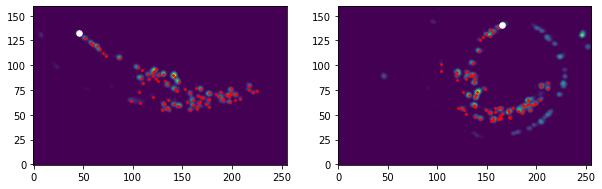

In [176]:
%matplotlib inline
i1,i2=np.random.choice(T,2,replace=False)
fr1=(dataset.get_frame(i1)/255).astype(np.float32)
fr2=(dataset.get_frame(i2)/255).astype(np.float32)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(fr1[0,:,:,:].max(2).T,origin="lower")
plt.scatter(*points[i1,:,:2].T,c="r",s=3)
plt.scatter(*points[i1,75,:2].T,c="w",s=30)
plt.subplot(122)
plt.imshow(fr2[0,:,:,:].max(2).T,origin="lower")
plt.scatter(*points[i2,:,:2].T,c="r",s=3)
plt.scatter(*points[i2,75,:2].T,c="w",s=30)

In [196]:
def lip(deformation):
    dx=torch.abs(deformation[0,1:]-deformation[0,:-1])
    dy=torch.abs(deformation[1,:,1:]-deformation[1,:,:-1])
    dz=torch.abs(deformation[2,:,:,1:]-deformation[2,:,:,:-1])
    return torch.relu(dx-1).mean()+torch.relu(dy-1).mean()+torch.relu(dz-1).mean()

def get_at_coords(image,coords):
    C,W,H,D=image.shape
    coords=coords[:,None,None,:].clone()
    coords[...,0]/=(W-1)/2
    coords[...,0]-=1
    coords[...,1]/=(H-1)/2
    coords[...,1]-=1
    coords[...,2]/=(D-1)/2
    coords[...,2]-=1
    coords=coords[...,[2,1,0]]
    res=torch.nn.functional.grid_sample(image[None],coords[None], mode='bilinear', padding_mode="zeros",align_corners=True)[0]
    return res[:,:,0,0].T

def get_deformation_lowk2(ptfrom,ptto,sh,k_cut_dimless=2.5,lr=0.1,iterations=200,lambda_lip=100,scale=(1,1,1),at_least=5,device="cpu",verbose=False,return_losses=False):
    vecs=(ptfrom-ptto)
    valids=np.nonzero(np.all(np.isnan(vecs)==0,axis=1))[0]
    if len(valids)<at_least:
        return None,"Not enough points"
    vecs=vecs[valids][:,:]
    locs=ptto[valids][:,:]
    W,H,D=sh

    f=Deformation.FourierLowK((W,H,D),k_cut_dimless=k_cut_dimless)

    locs=torch.tensor(locs,dtype=torch.float32,device=device)
    vecs=torch.tensor(vecs,dtype=torch.float32,device=device)

    x=torch.zeros(1,3,f.dim)
    #initialize the displacement field as the mean displacement
    x[0,:,0]=vecs.mean(0)
    x=x.to(device=device)
    x=torch.nn.Parameter(x)
    opt=torch.optim.Adam([x],lr=lr)
    if return_losses:
        losses=[]
    for iters in range(iterations):
        deformation=f(x)[0]
        vecs_sampled=get_at_coords(deformation,locs)
        loss=torch.nn.functional.l1_loss(vecs_sampled,vecs)
        lip_loss=lip(deformation)
        loss+=lambda_lip*lip_loss
        opt.zero_grad()
        loss.backward()
        opt.step()
        if return_losses:
            losses.append(loss.item())
        if verbose:
            print(loss.item())
    if return_losses:
        return deformation[0],losses,"success"
    return deformation[0],"success"

def get_deformation_lowk(ptfrom,ptto,sh,k_cut_dimless=2.5,lr=0.1,iterations=200,lambda_div=1,scale=(1,1,1),at_least=5,device="cpu",verbose=False,return_losses=False):
    vecs=(ptto-ptfrom)
    valids=np.nonzero(np.all(np.isnan(vecs)==0,axis=1))[0]
    if len(valids)<at_least:
        return None,"Not enough points"
    vecs=vecs[valids][:,:]
    locs=ptfrom[valids][:,:]
    W,H,D=sh

    f=Deformation.FourierLowK((W,H,D),k_cut_dimless=k_cut_dimless)

    locs_gridded=2*(torch.tensor(locs)[:,None,None,None,:]/(np.array([W,H,D])[None,None,None,None,:]-1))-1#MB: I rhink with None we add unit axis
    locs_gridded=locs_gridded[...,[2,1,0]].to(device=device,dtype=torch.float32)
    vecs_target=torch.tensor(vecs).to(device=device,dtype=torch.float32)

    x=torch.zeros(1,3,f.dim)
    #initialize the displacement field as the mean displacement
    x[0,:,0]=torch.tensor(np.mean(vecs,axis=0))
    x=x.to(device=device)
    x=torch.nn.Parameter(x)
    opt=torch.optim.Adam([x],lr=lr)
    if return_losses:
        losses=[]
    for iters in range(iterations):
        deformation=f(x)
        #deformation=torch.mean(deformation,dim=4,keepdim=True).repeat(1,1,1,1,deformation.size(4))#mean over z axis
        vecs_sampled=torch.nn.functional.grid_sample(deformation.repeat(locs_gridded.size(0),1,1,1,1),locs_gridded, mode='bilinear', padding_mode='border',align_corners=True)[:,:,0,0,0]
        loss=torch.nn.functional.l1_loss(vecs_sampled,vecs_target)#this is where the points that are mapped to each other are included
        gx=deformation[:,0,2:,1:-1,1:-1]-deformation[:,0,:-2,1:-1,1:-1]#how far is each pixel from the previous one in the direction of x
        gy=deformation[:,1,1:-1,2:,1:-1]-deformation[:,1,1:-1,:-2,1:-1]
        gz=deformation[:,2,1:-1,1:-1,2:]-deformation[:,2,1:-1,1:-1,:-2]
        divergence=scale[0]*gx+scale[1]*gy+scale[2]*gz
        loss+=lambda_div*torch.mean(torch.abs(divergence))
        #print(f.kgrid.shape)
        opt.zero_grad()
        loss.backward()
        opt.step()
        if return_losses:
            losses.append(loss.item())
        if verbose:
            print(loss.item())
    if return_losses:
        return deformation[0],losses,"success"
    return deformation[0],"success"

In [236]:
deformation,losses,msg=get_deformation_lowk(points[i2],points[i1],sh,k_cut_dimless=1,lr=0.1,iterations=400,lambda_div=1,scale=(1,1,4),at_least=5,device=device,verbose=False,return_losses=True)
msg

'success'

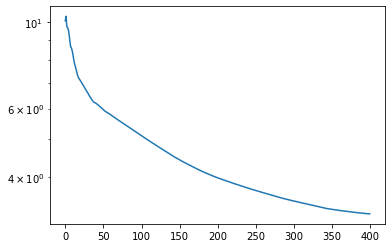

In [237]:
plt.plot(losses)
plt.yscale("log")

In [171]:
importlib.reload(Deformation)

<module 'src.methods.neural_network_tools.Deformation' from '/home/cfpark00/TrackingGUI/src/methods/neural_network_tools/Deformation.py'>

In [119]:
#deformation,msg=Deformation.get_deformation_tps(points[i2],points[i1],grid,scale=data_info["pixel_scale"],device=device)
#msg

'success'

In [387]:
#inv_deformation=Deformation.invert_deformation(deformation,n_iter=10)

In [351]:
#inv_deformation=inv_deformation.mean(3)[:,:,:,None]
#inv_deformation[2]=0

In [225]:
deformation[:,:,:,:]=deformation[:,:,:,:].mean(3,keepdim=True)

In [238]:
deformation/=5

In [239]:
res=Deformation.deform(torch.tensor(fr1,device=device),deformation,mask=None)
res=res.cpu().detach().numpy()

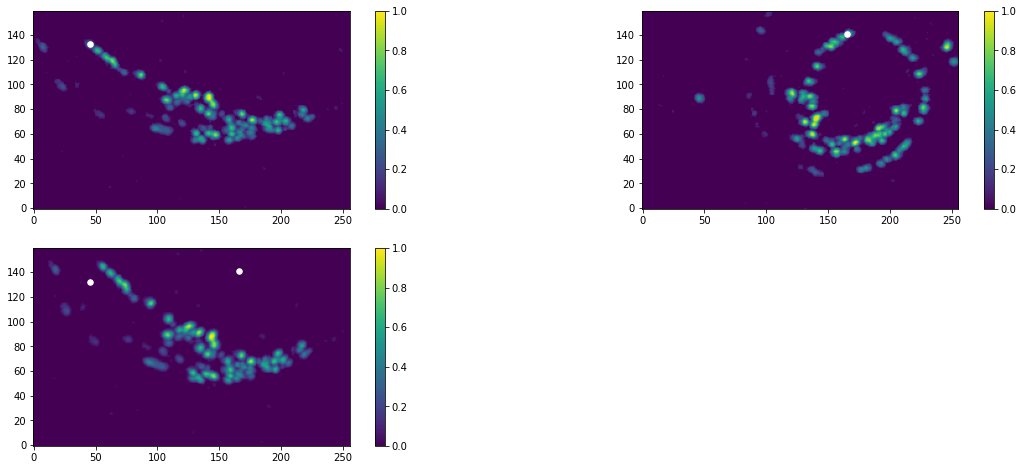

In [240]:
plt.figure(figsize=(20,8))
plt.subplot(221)
plt.imshow(fr1[0,:,:,:].max(2).T**0.5,origin="lower")
plt.scatter(*points[i1,75,:2].T,c="w",s=30)
plt.colorbar()
plt.subplot(222)
plt.imshow(fr2[0,:,:,:].max(2).T**0.5,origin="lower")
plt.scatter(*points[i2,75,:2].T,c="w",s=30)
plt.colorbar()
plt.subplot(223)
plt.imshow(res[0,:,:,:].max(2).T**0.5,origin="lower")
plt.scatter(*points[i2,75,:2].T,c="w",s=30)
plt.scatter(*points[i1,75,:2].T,c="w",s=30)
plt.colorbar()
#plt.subplot(223)
#plt.imshow(np.abs(res[0,:,:,:]-fr1[0,:,:,:]).max(2).T,origin="lower")
#plt.colorbar()

In [388]:
res=Deformation.deform(torch.tensor(fr1,device=device),-inv_deformation,mask=None)
res=res.cpu().detach().numpy()

In [152]:
np.nonzero(~inds)

(array([  61,  604, 1159, 1222, 1578, 1625, 1960, 2043, 2106, 2254, 2358,
        2443, 2477, 2518, 2653]),)

In [273]:
import torch
im=torch.load("./data/data_temp/153-3GT2/TA/frames/2035.pt")
mask=torch.load("./data/data_temp/153-3GT2/TA/masks/2035.pt")

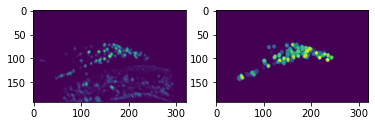

In [274]:
plt.figure()
plt.subplot(121)
plt.imshow(im[0].max(2)[0].T)
plt.subplot(122)
plt.imshow(mask.max(2)[0].T)

In [275]:
im=torch.load("./data/data_temp/153-3GT2/TA/frames/2035.pt")
mask=torch.load("./data/data_temp/153-3GT2/TA/masks/2035.pt")

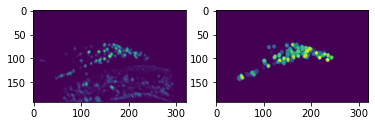

In [276]:
plt.figure()
plt.subplot(121)
plt.imshow(im[0].max(2)[0].T)
plt.subplot(122)
plt.imshow(mask.max(2)[0].T)

In [249]:
dataset.close()

In [ ]:
plt.scatter(*points[i1,75,:2].T,c="w",s=30)

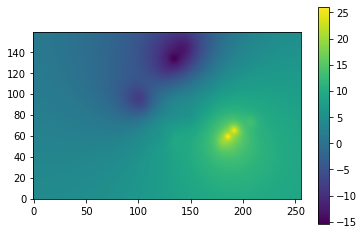

In [184]:
plt.imshow(deformation[1,:,:,9].cpu().detach().numpy().T,origin="lower")
plt.colorbar()

In [135]:
fol="data/data_temp/184-15GT2/TA/masks/"
import glob
import os
inds=[int(os.path.split(fp)[1].split(".")[0]) for fp in glob.glob(fol+"*")]

In [136]:
inds

[1030,
 1062,
 1541,
 2551,
 2721,
 2602,
 2084,
 1207,
 2447,
 893,
 526,
 2498,
 2256,
 998,
 647,
 2664,
 1325,
 2377,
 985,
 1213,
 2667,
 676,
 1404,
 2882,
 557,
 2833,
 1880,
 1128,
 1275,
 2061,
 424,
 754,
 1,
 2574,
 306,
 1259,
 421,
 372,
 129,
 1391,
 2435,
 509,
 788,
 408,
 2843,
 1581,
 2309,
 894,
 849,
 1406,
 1494,
 697,
 1297,
 497,
 972,
 2566,
 114,
 422,
 621,
 1019,
 2573,
 1887,
 537,
 944,
 2445,
 1679,
 1465,
 2703,
 1248,
 2080,
 854,
 317,
 2845,
 195,
 1706,
 1643,
 701,
 2538,
 1063,
 1055,
 2081,
 1475,
 1677,
 2782,
 194,
 12,
 2376,
 872,
 673,
 1048,
 2751,
 2176,
 288,
 2011,
 2095,
 2577,
 2251,
 376,
 2822,
 1429,
 2391,
 1155,
 1188,
 1768,
 2920,
 536,
 360,
 1131,
 64,
 2312,
 2530,
 1727,
 2382,
 855,
 110,
 301,
 2657,
 507,
 432,
 2749,
 1789,
 1438,
 1290,
 2427,
 2798,
 2139,
 2579,
 1720,
 1892,
 1263,
 197,
 530,
 1049,
 782,
 2480,
 1561,
 2489,
 2802,
 1660,
 542,
 2907,
 1697,
 585,
 2557,
 1333,
 1666,
 1536,
 206,
 2398,
 1246,
 2618

In [50]:
deformation.shape

torch.Size([3, 256, 160, 16])

In [13]:
dataset.close()

In [27]:
dataset=Dataset("data/2022_03_21_1.h5")
dataset.open()

In [28]:
fr=dataset.get_frame(0)

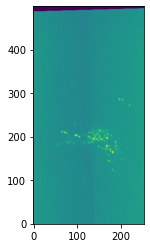

In [40]:
im=fr[0].max(2)
center=np.array(im.shape)/2-0.5
plt.imshow(im.T,origin="lower")

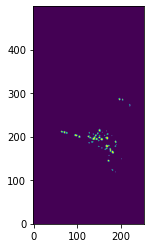

In [41]:
threshold=35
binmask=im>threshold
plt.imshow(binmask.T,origin="lower")

In [42]:
cm=sim.center_of_mass(im*binmask)
movementcm-center

array([ 22.25367447, -53.99923789])

In [25]:
dataset.close()

In [9]:
dataset=Dataset("/home/cfpark00/TrackingGUI/data/mili1-gt.h5")
dataset.open()
points=dataset.get_points()
dataset.close()

In [11]:
np.save("points.npy",points)

In [2]:
dataset=Dataset("/home/cfpark00/Projects/WormTracking/targettrack/data/184.h5")
dataset.open()
points=dataset.get_points()
dataset.close()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/cfpark00/Projects/WormTracking/targettrack/data/184.h5', errno = 2, error message = 'No such file or directory', flags = 1, o_flags = 2)

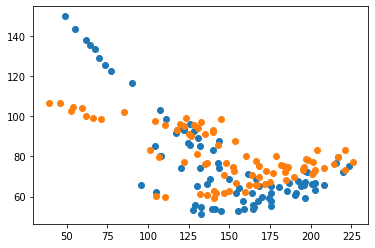

In [3]:
ptfrom=points[0]
ptto=points[100]
plt.scatter(*ptfrom[:,:2].T)
plt.scatter(*ptto[:,:2].T)

In [4]:
deformation,losses,msg=deformation.get_deformation(ptfrom,ptto,sh=(256,160,16),k_cut_dimless=2.5,lr=0.1,iterations=200,lambda_div=1,scale=(1,1,1),at_least=4,device="cuda",verbose=True,return_losses=True)

4.869450092315674
4.919613361358643
3.572965621948242
2.6245758533477783
2.8917317390441895
2.784406900405884
2.377760410308838
2.189540386199951
2.09248423576355
1.8094682693481445
1.604529619216919
1.5201798677444458
1.5096213817596436
1.475572943687439
1.4074437618255615
1.4056341648101807
1.409444808959961
1.3877288103103638
1.243016004562378
1.1371523141860962
1.0456931591033936
1.0602575540542603
1.031825304031372
1.0220222473144531
0.9543790817260742
0.9542558193206787
0.9625335335731506
0.9586924910545349
0.8873180150985718
0.8446359634399414
0.7950338125228882
0.7867451906204224
0.8079757690429688
0.7933118343353271
0.7538635730743408
0.7355953454971313
0.7380530834197998
0.7113739848136902
0.6954070329666138
0.6789027452468872
0.6751428842544556
0.6545417904853821
0.6609717011451721
0.6640117168426514
0.6332080960273743
0.6262078881263733
0.6198529005050659
0.6108863353729248
0.6228138208389282
0.5922449231147766
0.5897855162620544
0.579684853553772
0.5713846683502197
0.56620

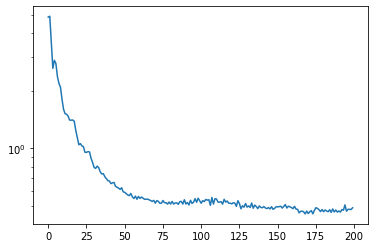

In [5]:
plt.plot(losses)
plt.yscale("log")

In [7]:
deformation.device

device(type='cuda', index=0)

In [34]:
import scipy.spatial as sspat
import numpy as np
from src.Dataset import Dataset
import scipy.interpolate as sintp

In [ ]:
points=np.load("./points.npy")
#ts=np.arange(len(points))
#f_intp=sintp.interp1d(ts,points,axis=0)
#ts_=np.linspace(0,len(points)-1,2500)
#points=f_intp(ts_)
#points=points[:,:,[1,0,2]]

In [ ]:
dataset=Dataset("./data/mili1.h5")
dataset.open()
dataset.set_data("points",points[:,:,[1,0,2]],compression=None,overwrite=True)
dataset.close()

In [ ]:
import scipy.spatial as sspat
import numpy as np

def interpolate_points(points,t_ref=0):
    """
    points (T,N+1,2) float32 : an array of coordinates for N points, np.nan where it doesn't exist, points[:,0] should be all nan
    t_ref reference time
    
    returns
    
    ptss (T,N+1,2) float32 an array of coordinates like points where coordinates for nans are interpolated
    """
    T=points.shape[0]
    points_ref=points[t_ref,1:]
    existing_ref=~np.isnan(points_ref[:,0])
    distmat=sspat.distance.squareform(sspat.distance.pdist(points_ref))
    np.fill_diagonal(distmat,np.nan)

    ptss=np.full_like(points,np.nan)
    for t in range(T):
        existing=~np.isnan(points[t,1:,0])
        if existing.sum()==0:
            pass
        todo=np.nonzero(~(existing*existing_ref))[0]
        for i in todo:
            validrefs=np.nonzero((~np.isnan(distmat[i]))*existing*existing_ref)[0]
            if len(validrefs)==0:
                continue
            weights=(1/(distmat[i,validrefs]+epsilon))**2
            vecs=points[t,validrefs+1,:2]-points_ref[validrefs,:2]
            vec=(weights[:,None]*vecs).sum(0)/weights.sum()
            ptss[t,1+i,:2]=points_ref[i]+vec
    return ptss

In [ ]:
ptss=interpolate_points(points[:,:,:2],t_ref=0)

In [ ]:
ptss.shape

In [ ]:
distmat=sspat.distance.squareform(sspat.distance.pdist(np.full((30,3),np.nan)))
distmat.shape